In [31]:
# Collaborative Filtering for Book Recommendations
# This notebook implements collaborative filtering to recommend books based on user ratings.
# It uses item-based collaborative filtering to find books similar to a target book.

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split

# Load book ratings data
book_ratings = pd.read_csv("BX-Book-Ratings.csv")

# Rename columns to match expected format
book_ratings.columns = ['user_id', 'item_id', 'rating']

# Since no book titles are available in the dataset, we'll use ISBN as a placeholder for title
book_ratings['title'] = book_ratings['item_id']

# Filter out implicit ratings (0 ratings are implicit in this dataset)
book_ratings = book_ratings[book_ratings['rating'] > 0]

# Filter users and items with few ratings
user_counts = book_ratings['user_id'].value_counts()
item_counts = book_ratings['item_id'].value_counts()
book_ratings = book_ratings[book_ratings['user_id'].isin(user_counts[user_counts >= 5].index)]
book_ratings = book_ratings[book_ratings['item_id'].isin(item_counts[item_counts >= 10].index)]

print(f"Filtered dataset shape: {book_ratings.shape}")
book_ratings.head(2)

Filtered dataset shape: (94363, 4)


,user_id,item_id,rating,title
16,276747,60517794,9.0,60517794
19,276747,671537458,9.0,671537458


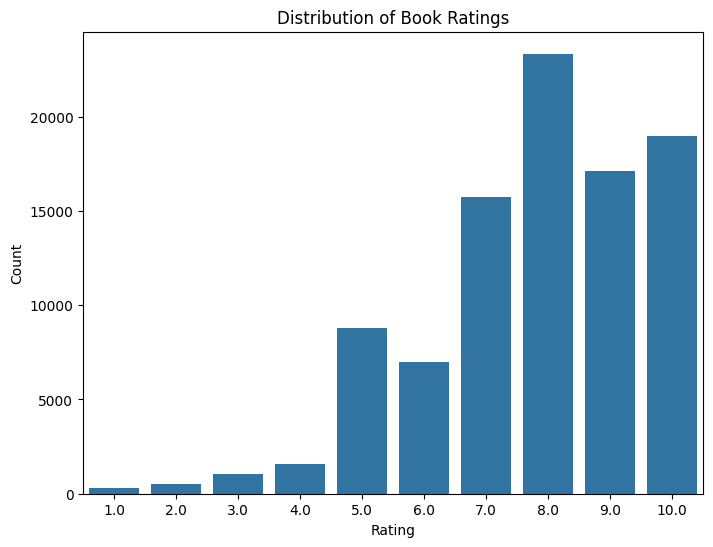

Top 5 highest rated books:


,rating,num_of_ratings
title,,
1888054557,10.000000,10
159184021X,10.000000,2
836213319,9.916667,12
312099045,9.900000,10
439425220,9.857143,21


In [32]:
# Data preprocessing and exploration

# Plot rating distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='rating', data=book_ratings)
plt.title('Distribution of Book Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.savefig('rating_distribution.png')
plt.show()

# Calculate average rating per book
mean_ratings = pd.DataFrame(book_ratings.groupby('title')['rating'].mean())
mean_ratings['num_of_ratings'] = pd.DataFrame(book_ratings.groupby('title')['rating'].count())

print("Top 5 highest rated books:")
mean_ratings.sort_values('rating', ascending=False).head(5)

In [33]:
# Create pivot table for collaborative filtering
pivot = book_ratings.pivot_table(index='user_id', columns='title', values='rating')

print(f"Pivot table shape: {pivot.shape}")
pivot.head()

Pivot table shape: (11156, 5038)


title,0,000648302X,000649840X,000716226X,002026478X,002542730X,006000438X,006001203X,006016848X,006017143X,...,99740516,99747200,99771012,99771519,99800403,99845008,99866005,99935708,99992000,99993805
user_id,,,,,,,,,,,,,,,,,,,,,
99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
# Item-based collaborative filtering
# Select a target book (using ISBN as example)
target_book = pivot.columns[0]  # First book in the dataset
print(f"Target book: {target_book}")

# Find correlations
selected_book_ratings = pivot[target_book]
similar_books = pivot.corrwith(selected_book_ratings)
similar_df = pd.DataFrame(similar_books, columns=['Correlation'])
similar_df.dropna(inplace=True)
similar_df = similar_df.join(mean_ratings['num_of_ratings'])

# Filter books with sufficient ratings
similar_df = similar_df[similar_df['num_of_ratings'] >= 50]
similar_df.sort_values('Correlation', ascending=False).head(10)

Target book: 0


C:\Users\Shanice.Nyongesa\AppData\Roaming\Python\Python314\site-packages\numpy\lib\_function_base_impl.py:3015: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\Shanice.Nyongesa\AppData\Roaming\Python\Python314\site-packages\numpy\lib\_function_base_impl.py:2888: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\Shanice.Nyongesa\AppData\Roaming\Python\Python314\site-packages\numpy\lib\_function_base_impl.py:2888: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\Shanice.Nyongesa\AppData\Roaming\Python\Python314\site-packages\numpy\lib\_function_base_impl.py:3023: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\Shanice.Nyongesa\AppData\Roaming\Python\Python314\site-packages\numpy\lib\_function_base_impl.py:3024: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,Correlation,num_of_ratings
title,,
385505833,1.0,79


In [35]:
# User-based collaborative filtering
def get_similar_users(user_id, n_similar=5):
    user_ratings = pivot.loc[user_id].dropna()
    similar_users = pivot.corrwith(user_ratings)
    similar_users = similar_users.dropna().sort_values(ascending=False)
    return similar_users.head(n_similar)

# Example: Get similar users for the first user in the dataset
user_id = pivot.index[0]
similar_users = get_similar_users(user_id)
print("Similar users:")
similar_users

Similar users:


Series([], dtype: float64)

Baseline RMSE: 1.7717


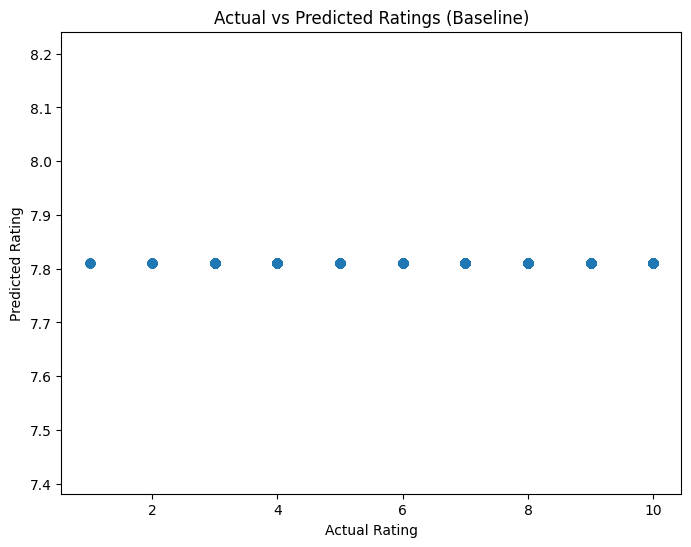

In [36]:
# Evaluation using RMSE
# Split data into train and test sets
train_data, test_data = train_test_split(book_ratings, test_size=0.2, random_state=42)

# Simple baseline: predict average rating
avg_rating = train_data['rating'].mean()
test_data['predicted_rating'] = avg_rating

# Calculate RMSE
rmse = sqrt(mean_squared_error(test_data['rating'], test_data['predicted_rating']))
print(f"Baseline RMSE: {rmse:.4f}")

# Plot actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(test_data['rating'], test_data['predicted_rating'], alpha=0.5)
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title('Actual vs Predicted Ratings (Baseline)')
plt.savefig('actual_vs_predicted.png')
plt.show()

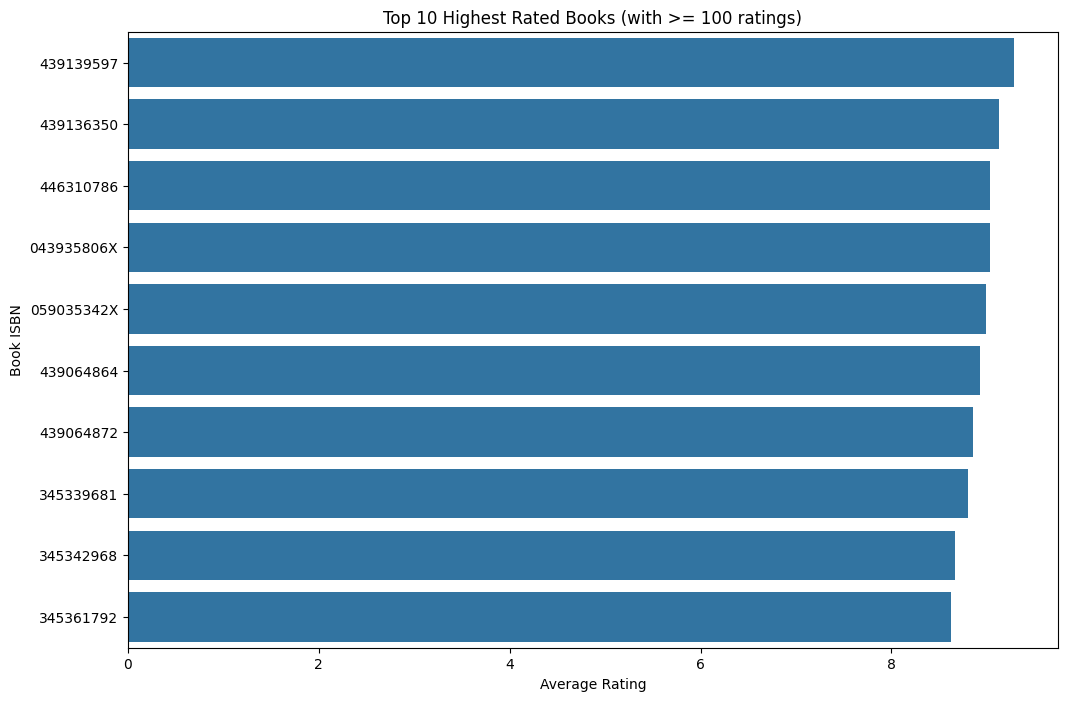

In [37]:
# Visualization: Top rated books
top_books = mean_ratings[mean_ratings['num_of_ratings'] >= 100].sort_values('rating', ascending=False).head(10)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_books['rating'], y=top_books.index)
plt.title('Top 10 Highest Rated Books (with >= 100 ratings)')
plt.xlabel('Average Rating')
plt.ylabel('Book ISBN')
plt.savefig('top_rated_books.png')
plt.show()